In [52]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

3.10.9


In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

bond_lengths = [i/20 for i=10:30]

md_list = ["h6_$(b)A_sto-3g_041623%2128.hdf5" for b in bond_lengths]

chemical_data_list = []

for (m,mol) in enumerate(md_list)

    cdata_list = ReadIn("../datasets/pyscf_data/"*mol);
    push!(chemical_data_list, cdata_list[1])
    PrintChemData(chemical_data_list[m])
    
end

Molecule name: h6_0.5A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/0.5.xyz
RHF energy: -1.4972824964759202
FCI energy: -1.6252356304515612
Molecule name: h6_0.55A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/0.55.xyz
RHF energy: -1.8548531754296924
FCI energy: -1.9860956716822145
Molecule name: h6_0.6A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/0.6.xyz
RHF energy: -2.103345770998299
FCI energy: -2.238568671359401
Molecule name: h6_0.65A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/0.65.xyz
RHF energy: -2.275008849157185
FCI energy: -2.4150646452529116
Molecule name: h6_0.7A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/0.7.xyz
RHF energy: -2.3916749600456253
FCI energy: -2.537638565108473
Molecule name: h6_0.75A
Basis set: sto-3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/0.75.xyz
RHF energy: -2.468523492771106
FCI energy: -2.62376590

In [38]:
# Standardized sweep objects:
opt_sweeps20 = Sweeps(40)
maxdim!(opt_sweeps20,20)
mindim!(opt_sweeps20,20)
cutoff!(opt_sweeps20,1e-12)
setnoise!(opt_sweeps20, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

opt_sweeps10 = Sweeps(40)
maxdim!(opt_sweeps10,10)
mindim!(opt_sweeps10,10)
cutoff!(opt_sweeps10,1e-12)
setnoise!(opt_sweeps10, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

opt_sweeps4 = Sweeps(40)
maxdim!(opt_sweeps4,4)
mindim!(opt_sweeps4,4)
cutoff!(opt_sweeps4,1e-12)
setnoise!(opt_sweeps4, 1e-3,1e-3,1e-3,1e-4,1e-4,1e-4,1e-5,1e-5,1e-5,1e-6,1e-6,1e-6,1e-7)

# Geometry optimization parameters:
gp0 = GeomParameters(
    a_maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=1e1
)

# Number of MultiGeomOptim repetitions:
#nreps = 4

op0 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    sd_dtol=1e-4,
    delta=[1e-1],
    ttol=10.0
)

op1 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    sd_dtol=1e-4,
    delta=[0.0],
    ttol=10.0,
    sd_method="triple_geneig",
    sd_maxiter=2000,
    sd_penalty=1.0-1e-5
);

In [53]:
##### Collect the various estimates:

e_dmrg10_vec = []
e_dmrg4_vec = []
e_nomps_vec = []
e_tnqe_vec = []
Ipq_vec = []

# Repeat for each geometry:
for m0=4:4
    
    m = 4*m0
    
    cdata = chemical_data_list[m]
    
    println("\n\n##### MOLECULAR GEOMETRY $(m)/$(length(bond_lengths)): #####\n\n")
    
    # This DMRG object is for determining bipartition entropies:
    dmrg1 = GenSubspace(cdata, 1, psi_maxdim=20);
    dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt) for j=1:dmrg1.mparams.M]
    
    GenStates!(dmrg1, verbose=true, sweeps=opt_sweeps20);
    GenPermOps!(dmrg1, verbose=true)
    GenSubspaceMats!(dmrg1, verbose=true)
    
    S1, S2, Ipq = MutualInformation(dmrg1.psi_list[1], dmrg1.chem_data)
    
    push!(Ipq_vec, Ipq)
    
    opt_ord = InfDistAnnealing(
        Ipq, 
        1, 
        gp0,
        verbose=false
    )[1]
    
    println("\n\n##### DMRG m=10 #####\n")
    # DMRG with bond dimension 10:
    dmrg10 = GenSubspace(cdata, 1, psi_maxdim=10)
    dmrg10.ord_list = [opt_ord]
    
    GenPermOps!(dmrg10, verbose=true)
    GenStates!(dmrg10, sweeps=opt_sweeps10, verbose=true)
    GenSubspaceMats!(dmrg10, verbose=true)
    
    push!(e_dmrg10_vec, dmrg10.H_mat[1,1]+cdata.e_nuc)
    println(e_dmrg10_vec[end])
    println(CountNonZeros(dmrg10.psi_list))
    
    
    println("\n\n##### DMRG m=4 #####\n")
    # DMRG with bond dimension 4:
    dmrg4 = GenSubspace(cdata, 1, psi_maxdim=3)
    dmrg4.ord_list = [opt_ord]
    
    GenPermOps!(dmrg4, verbose=true)
    GenStates!(dmrg4, sweeps=opt_sweeps4, verbose=true)
    GenSubspaceMats!(dmrg4, verbose=true)
    
    push!(e_dmrg4_vec, dmrg4.H_mat[1,1]+cdata.e_nuc)
    println(e_dmrg4_vec[end])
    println(CountNonZeros(dmrg4.psi_list))
    
    println("\n\n##### NOMPS m=4 #####\n")
    # NOMPS with 6 states, bond dimension 4:
    nomps = GenSubspace(cdata, 6, psi_maxdim=4, thresh="inversion", eps=1e-8)
    nomps.ord_list = [opt_ord for j=1:nomps.mparams.M]
    
    GenPermOps!(nomps, verbose=true)
    GenHams!(nomps)
    GenStates!(nomps, randomize=true, verbose=true)
    GenSubspaceMats!(nomps, verbose=true)
    SolveGenEig!(nomps, thresh="inversion", eps=1e-8, verbose=false)
    
    # Optimize:
    for k=1:2
        OneSitePairSweep!(
            nomps,
            op0,
            verbose=true
        )

        TwoSitePairSweep!(
            nomps,
            op1,
            verbose=true
        )
    end
    
    OneSitePairSweep!(
        nomps,
        op1,
        verbose=true
    )
    
    push!(e_nomps_vec, nomps.E[1]+cdata.e_nuc)
    println(e_nomps_vec[end])
    println(CountNonZeros(nomps.psi_list))
    
    
    println("\n\n##### TNQE m=4 #####\n")
    # TNQE with 6 states, bond dimension 4:
    tnqe1 = GenSubspace(cdata, 6, psi_maxdim=4, thresh="inversion", eps=1e-8)
    
    
    tnqe1.ord_list = InfDistAnnealing(
        Ipq, 
        tnqe1.mparams.M, 
        gp0,
        verbose=false
    )
    
    GenPermOps!(tnqe1, verbose=true)
    GenHams!(tnqe1)
    GenStates!(tnqe1, randomize=true, verbose=true)
    
    GenSubspaceMats!(tnqe1, verbose=true)
    SolveGenEig!(tnqe1, thresh="inversion", eps=1e-6, verbose=false)
    
    # Optimize:
    for k=1:2

        OneSitePairSweep!(
            tnqe1,
            op0,
            verbose=true
        )

        TwoSitePairSweep!(
            tnqe1,
            op1,
            verbose=true
        )
    end
    
    OneSitePairSweep!(
        tnqe1,
        op1,
        verbose=true
    )
    
    push!(e_tnqe_vec, tnqe1.E[1]+cdata.e_nuc)
    println(e_tnqe_vec[end])
    println(CountNonZeros(tnqe1.psi_list))
    
end



##### MOLECULAR GEOMETRY 16/21: #####


Generating states:
Progress: [1/1] 
Done!
Generating permutation operators:

Done!



##### DMRG m=10 #####

Generating permutation operators:

Done!

Generating states:
Progress: [1/1] 
Done!
-2.7735249481266138
164


##### DMRG m=4 #####

Generating permutation operators:

Done!

Generating states:
Progress: [1/1] 
Done!
-2.673278619003341
46


##### NOMPS m=4 #####

Generating permutation operators:
Progress: [15/15] 
Done!

Generating states:
Progress: [6/6] 
Done!

TWO-STATE, ONE-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 18/18; sweep: 1/1; site: 6/6; E_min = -6.88809; kappa = 4.59     
Done!


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 18/18; sweep: 1/1; bond: 5/5; E_min = -7.00051; kappa = 4.94     
Done!


TWO-STATE, ONE-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 18/18; sweep: 1/1; site: 6/6; E_min = -6.98808; kappa = 2.86     
Done!


TWO-STATE, TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; pair: 18/18; sweep: 1/1; bond: 5/5; E_min = -7.0018

In [56]:
# Here is the data from two separate runs combined (reproducible with above code):

m_subset = [4,6,8,10,12,14,16,18]

bond_subset = bond_lengths[m_subset]

e_rhf_vec = [chemical_data_list[m].e_rhf for m in m_subset]
e_fci_vec = [chemical_data_list[m].e_fci for m in m_subset]

# -2.7750614858222304,
# -2.7805831392937215,

e_nomps_vec = [
    -2.4125665731336063,
    -2.620022873233917,
    -2.712428111877034,
    -2.755879007553534,
    -2.7599876369737597,
    -2.7712627664162257,
    -2.7749504365952014,
    -2.6744762000451954
]

e_tnqe_vec = [
    -2.413812678107849,
    -2.6211453146755277,
    -2.716445024122822,
    -2.760633368803849,
    -2.7762028869965665,
    -2.7905798069624925,
    -2.789506369014136,
    -2.798840008528208
];


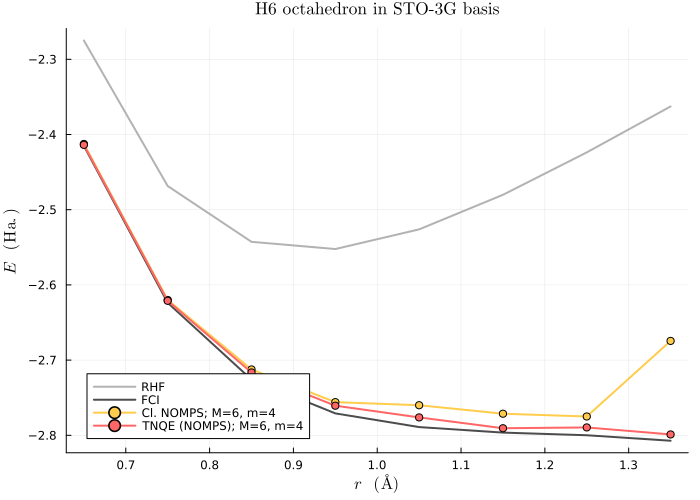

In [57]:
using LaTeXStrings

plot(
    bond_subset, 
    e_rhf_vec, 
    color=RGB(0.7,0.7,0.7), 
    linewidth=2.0,
    label="RHF",
    title="H6 octahedron in STO-3G basis",
    titlefontsize=11.0,
    titlefont=font(14,"Computer Modern"),
    xguide=L"r\quad(\AA)",
    yguide=L"E\quad(\textrm{Ha.})",
    size=(700,500)
)

plot!(
    bond_subset, 
    e_fci_vec, 
    color=RGB(0.3,0.3,0.3), 
    linewidth=2.0,
    label="FCI"
)

plot!(
    bond_subset, 
    e_nomps_vec, 
    color=color=RGB(1.0,0.8,0.3), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="Cl. NOMPS; M=6, m=4"
)

plot!(
    bond_subset, 
    e_tnqe_vec, 
    color=color=RGB(1.0,0.4,0.4), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="TNQE (NOMPS); M=6, m=4"
)

#savefig("../plots/H6_Octahedron/RHF-to-FCI_comparison.pdf")


In [58]:
plot(
    bond_subset[3:end],
    e_fci_vec[3:end].+0.0016,
    fillrange = e_fci_vec[3:end].-0.0016,
    color = RGB(0.3,0.8,0.5),
    fillalpha = 0.2,
    label = "Chem. acc.",
    title="H6 octahedron in STO-3G basis",
    titlefontsize=11.0,
    titlefont=font(14,"Computer Modern"),
    xguide=L"r\quad(\AA)",
    yguide=L"E\quad(\textrm{Ha.})",
    size=(700,500)
)

plot!(
    bond_subset[3:end],
    e_fci_vec[3:end].-0.0016,
    color = RGB(0.3,0.8,0.5),
    primary=false
)

plot!(
    bond_subset[3:end], 
    e_fci_vec[3:end], 
    color=RGB(0.3,0.3,0.3), 
    linewidth=2.0,
    label="FCI"
)

plot!(
    bond_subset[3:end], 
    e_nomps_vec[3:end], 
    color=color=RGB(1.0,0.8,0.3), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="Cl. NOMPS; M=6, m=4"
)

plot!(
    bond_subset[3:end], 
    e_tnqe_vec[3:end], 
    color=color=RGB(1.0,0.4,0.4), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="TNQE (NOMPS); M=6, m=4"
)

savefig("../plots/H6_Octahedron/ChemAcc_comparison.pdf")

"/home/oskar/Documents/TNQE/TNQE-Julia/plots/H6_Octahedron/ChemAcc_comparison.pdf"

In [14]:
"""
plot!(
    bond_lengths, 
    e_dmrg8_vec, 
    color=RGB(0.4,0.4,1.0), 
    linewidth=2.0,
    markersize=4,
    markershape=:circle,
    label="DMRG; m=8"
)
"""

"plot!(\n    bond_lengths, \n    e_dmrg8_vec, \n    color=RGB(0.4,0.4,1.0), \n    linewidth=2.0,\n    markersize=4,\n    markershape=:circle,\n    label=\"DMRG; m=8\"\n)\n"

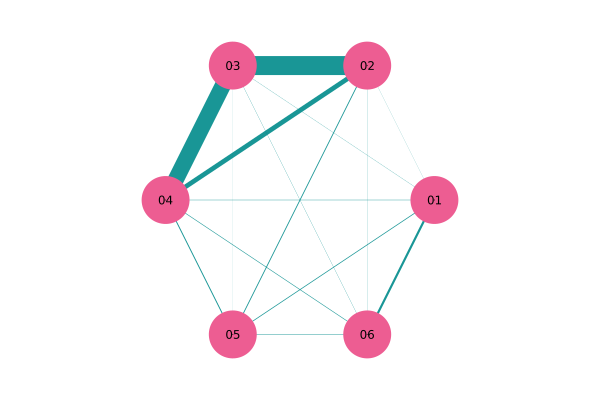

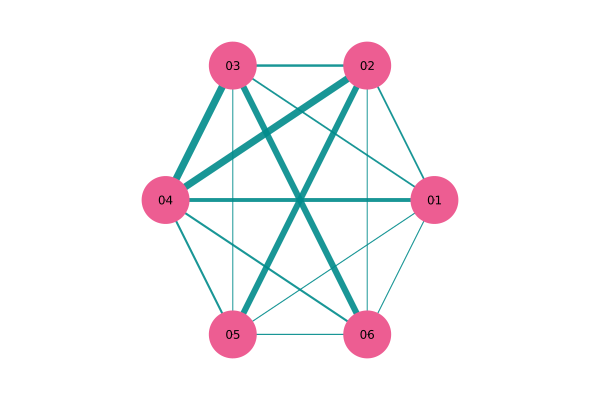

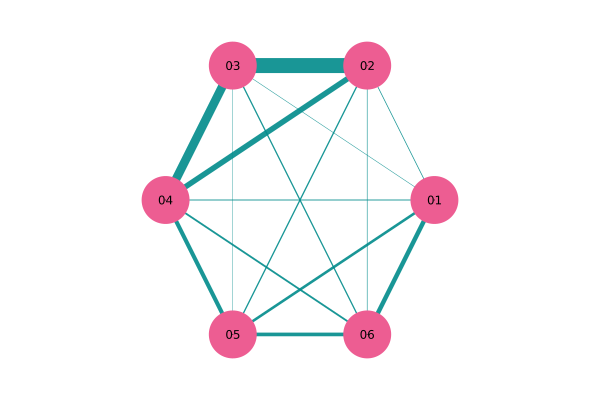

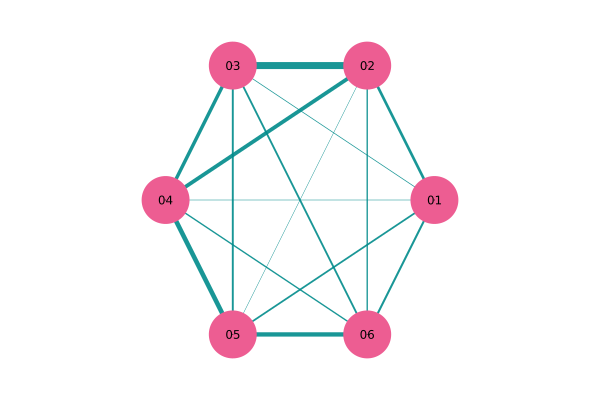

In [15]:
for (m, Ipq) in enumerate(Ipq_vec)
    
    OrbitalGraphPlot(Ipq, multiplier=3e1)
    
    savefig("../plots/H2O_DoubleDissoc/MutualInformation/r=$(bond_lengths[m]).svg")
    
end

In [16]:
display(e_nomps_vec)
display(e_tnqe_vec)

4-element Vector{Any}:
 -2.620022873233917
 -2.755879007553534
 -2.7712627664162257
 -2.6744762000451954

4-element Vector{Any}:
 -2.6211453146755277
 -2.760633368803849
 -2.7905798069624925
 -2.798840008528208

In [2]:
bond_lengths = [i/20 for i=10:30]

m_subset = [4,6,8,10,12,14,16,18]

bond_subset = bond_lengths[m_subset]

8-element Vector{Float64}:
 0.65
 0.75
 0.85
 0.95
 1.05
 1.15
 1.25
 1.35